In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

import cartopy.crs as ccrs
import cartopy.feature as cf
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean

In [2]:
import graphufs

plt.style.use("graphufs.plotstyle")

/contrib2/Tim.Smith/graph-ufs/graphufs/training.py:59: UserWarning: Import failed for either mpi4py or mpi4jax.
  warnings.warn("Import failed for either mpi4py or mpi4jax.")


In [3]:
def swap_dims(xds):

    if "prediction_timedelta" in xds.coords and "lead_time" not in xds.coords:
        xds = xds.rename({"prediction_timedelta": "lead_time"})
    
    xds["fhr"] = (xds.lead_time.astype(int) / 3600 / 1e9).astype(int)
    xds = xds.swap_dims({"lead_time": "fhr"})
    return xds

In [4]:
def open_dataset(*args, **kwargs):
    xds = xr.open_dataset(*args, **kwargs)
    xds = swap_dims(xds)
    return xds

In [5]:
def open_zarr(*args, **kwargs):
    xds = xr.open_zarr(*args, **kwargs)
    xds = swap_dims(xds)
    
    xds["valid_time"] = xds.time + xds.lead_time
    xds = xds.set_coords("valid_time")
    return xds

In [6]:
gds = open_zarr("/p1-evaluation/v1/training/graphufs.240h.zarr/")

In [7]:
era = xr.open_zarr(
    "gs://weatherbench2/datasets/era5/1959-2023_01_10-full_37-1h-0p25deg-chunk-1.zarr",
    storage_options={"token": "anon"},
)
era = era.sel(
    time=slice(
        gds.time.isel(time=0).values,
        gds.valid_time.isel(time=-1, fhr=-1).values
    ),
    level=[100,500,850],
)

In [8]:
gds["10m_wind_speed"] = np.sqrt(gds["ugrd10m"]**2 + gds["vgrd10m"]**2)
era["10m_wind_speed"] = np.sqrt(era["10m_u_component_of_wind"]**2 + era["10m_v_component_of_wind"]**2)

In [9]:
class SpatialMap():
    defaults = {
        "tmp2m": {
            "vmax": 30,
            "vmin": -10,
            "cmap": "cmo.thermal",
            "label": "2m Temperature ($^\circ$C)",
        },
        "10m_wind_speed": {
            "vmax": 25,
            "vmin": 0,
            "cmap": "cmo.speed",
            "label": "10m Horizontal Wind Speed (m/s)",
        },
    }

    central_longitude = -80
    central_latitude = 20

    def __init__(self, **kwargs):

        for key, val in kwargs.items():
            try:
                getattr(self, key)
                setattr(self, key, val)
            except:
                print(f"No attr {key}, ignoring kwarg")

    @staticmethod
    def get_figsize(ncols):
        return (5*ncols, 6)

    @staticmethod
    def get_extend(xdslist, vmin, vmax):
        minval = np.min([xds.min().values for xds in xdslist])
        maxval = np.max([xds.max().values for xds in xdslist])
        vmin = minval if vmin is None else vmin
        vmax = maxval if vmax is None else vmax

        extend = "neither"
        if minval < vmin:
            extend = "min"
        if maxval < vmax:
            extend = "max" if extend == "neither" else "both"

        return extend, vmin, vmax
    

    def plot(self, gda, tda, itime, fhr, subselect=False, **kwargs):

        # select in time
        gda = gda.isel(time=itime).sel(fhr=fhr)
        t0 = gda.time.values
        date = t0 + pd.Timedelta(f"{fhr}h")
        tda = tda.sel(time=date)

        if subselect:
            tda = tda.isel(latitude=slice(None, None, 4), longitude=slice(None, None, 4))
        
        fig, axs = plt.subplots(
            1,2,
            figsize=self.get_figsize(2),
            constrained_layout=True,
            subplot_kw={
                "projection": ccrs.Orthographic(
                    central_longitude=self.central_longitude,
                    central_latitude=self.central_latitude,
                ),
            },
        )
        for key in ["vmax", "vmin", "cmap"]:
            if key not in kwargs and gda.name in self.defaults.keys():
                kwargs[key] = self.defaults[gda.name][key]
                
        if gda.name in self.defaults.keys():
            label = self.defaults[gda.name]["label"]
        else:
            label = f"{gda.name} ({tda.attrs['units']})"

        if gda.name == "tmp2m":
            gda = gda - 273.15
            tda = tda - 273.15

        extend, kwargs["vmin"], kwargs["vmax"] = self.get_extend([gda, tda], kwargs["vmin"], kwargs["vmax"])
        kw = {"transform": ccrs.PlateCarree(), "add_colorbar": False, **kwargs}
                
        p = gda.plot(ax=axs[0], **kw)
        tda.plot(ax=axs[1], x="longitude", **kw)
        
        [ax.add_feature(cf.COASTLINE) for ax in axs];
        axs[0].set(title=f"GraphUFS, {str(t0)[:13]} + 24h")
        axs[1].set(title=f"ERA5, {str(date)[:13].replace(' ', 'T')}");
        fig.colorbar(p, ax=axs, orientation="horizontal", shrink=.6, aspect=35, label=label, extend=extend)
        return fig, axs
    

In [10]:
mapper = SpatialMap()

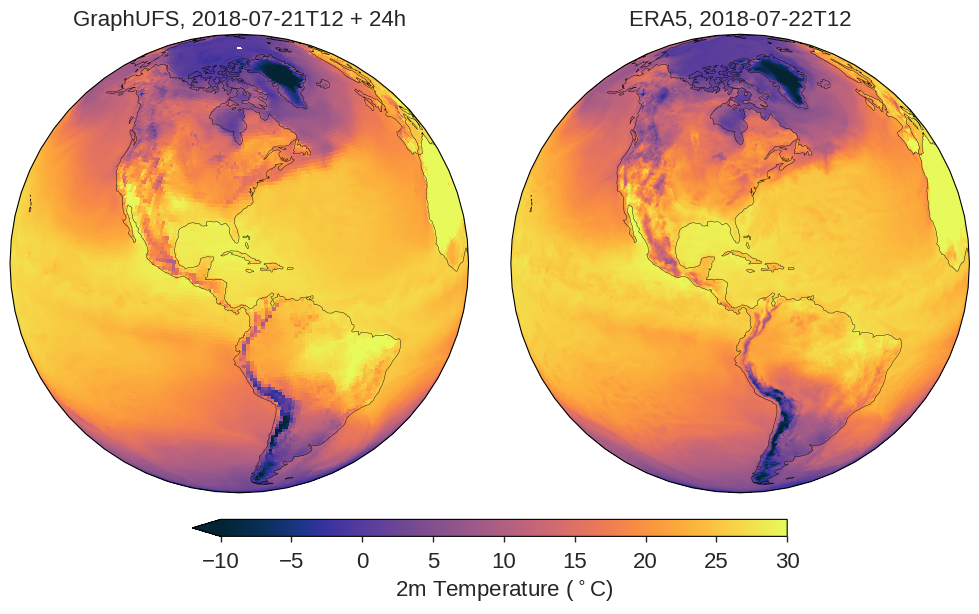

In [11]:
fig, axs = mapper.plot(gds["tmp2m"], era["2m_temperature"], itime=179, fhr=24)
fig.savefig(f"figures/graphufs_and_era5_tmp2m_24h.jpeg", bbox_inches="tight", dpi=300)

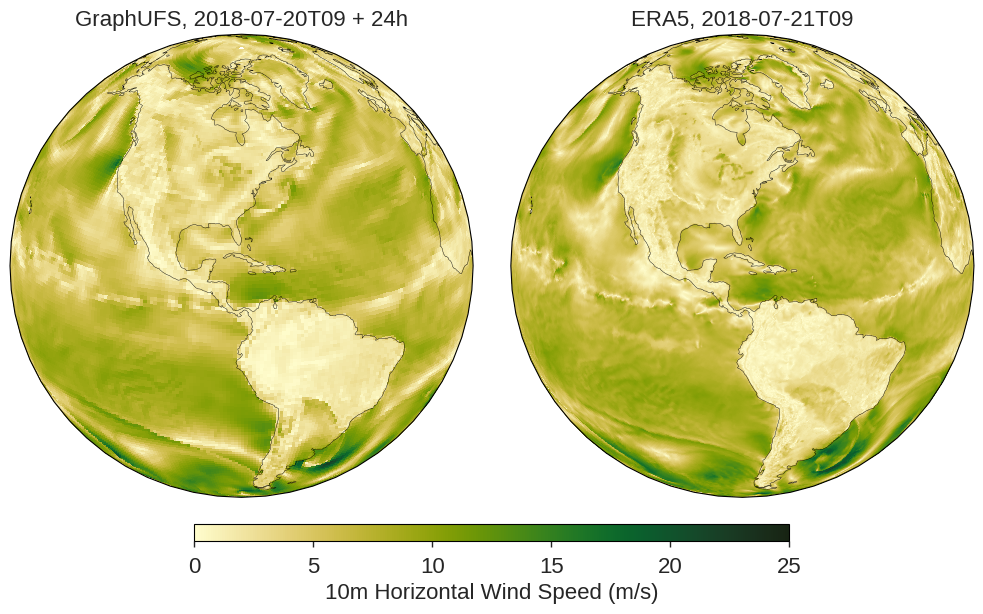

In [12]:
fig, axs = mapper.plot(gds["10m_wind_speed"], era["10m_wind_speed"], itime=178, fhr=24)
fig.savefig(f"figures/graphufs_and_era5_windspeed_24h.jpeg", bbox_inches="tight", dpi=300)